In [1]:
import numpy as np
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import open3d as o3d


file = "./results/ex1front_pred.ply"

pcd = o3d.io.read_point_cloud(file)
xyz = np.array(pcd.points)

# left_arm = [627, 628, 789, 1232, 1233, 1311, 1315, 1378, 1379, 1381, 1382, 1385, 1388, 1389, 1393, 1394, 1396, 1397]
left_calf = [1087, 1088, 1091, 1092, 1096, 1097, 1099, 1100, 1103, 1155, 1371, 1464, 1467, 1469, 1528]
xyz = xyz[left_calf]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
fig = go.Figure(data=[go.Scatter3d(x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2], mode="markers", marker=dict(size=5))])
fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"), title="3D Scatter Plot")
fig.show()

In [3]:
from skspatial.objects import Plane, Points

points = Points(xyz)
plane = Plane.best_fit(points)
normal = np.array(plane.normal)

In [12]:
import trimesh

n = 1
file = f"./results/ex{n}front_pred.ply"

# Load the PLY file
mesh = trimesh.load_mesh(file)

# Create a scene with the mesh and set its color
scene = trimesh.Scene(mesh)
scene.add_geometry(mesh)

# Plot the scene
scene.show()

In [60]:
import json

with open("./SMPL_index_measure.json") as json_file:
    indexes = json.load(json_file)

file = "./results/ex1front_pred.ply"
real_height = 1.73
# real_height = 1.69
# real_height = 1.83

pcd = o3d.io.read_point_cloud(file)

xyz = np.array(pcd.points)
xyz_chest = xyz[indexes["chest"]]

upper_y = np.mean(xyz[indexes["head_tip"]][:, 1])
lower_y = np.mean(xyz[indexes["feet_soles"]][:, 1])
smpl_height = upper_y - lower_y

points = Points(xyz_chest)
plane = Plane.best_fit(points)
normal = np.array(plane.normal)


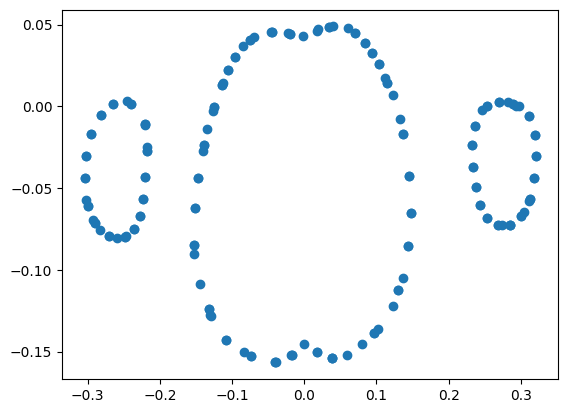

In [7]:
isect, face_inds = trimesh.intersections.mesh_plane(
    mesh,
    plane_normal=normal,
    plane_origin=plane.project_point(xyz_chest[0]),
    return_faces=True
)
plt.scatter(*isect[:,0,0::2].T)
plt.show()

In [112]:
slice = mesh.section(plane_origin=plane.project_point(xyz_chest[0]),
                     plane_normal=normal)

slice.show()

AttributeError: 'PointCloud' object has no attribute 'section'

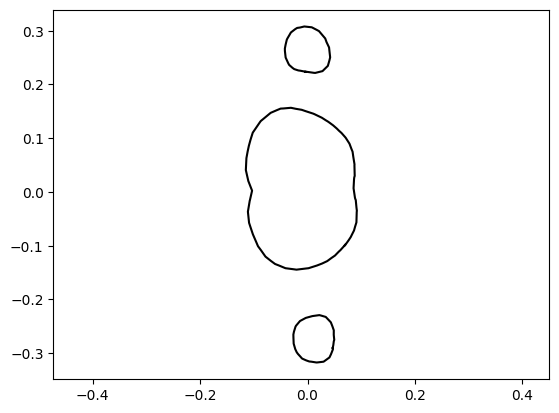

In [14]:
# we can move the 3D curve to a Path2D object easily
slice_2D, to_3D = slice.to_planar()
slice_2D.show()

In [15]:
slice_2D.remove_entities([0,2])

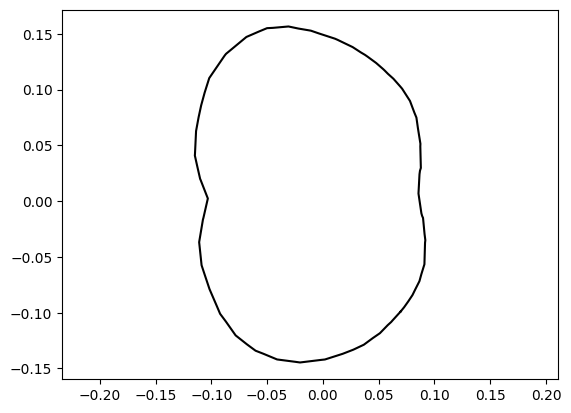

In [16]:
slice_2D.show()

In [17]:
slice_2D.length * real_height / smpl_height

0.9104732850151178

In [40]:
chest_curve = np.array(isect[:,0,0::2])

In [16]:
chest_curve.shape

(172, 2)

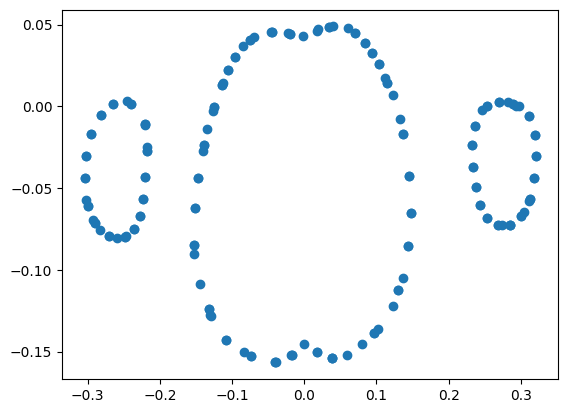

In [44]:
plt.scatter(chest_curve[:,0], chest_curve[:,1])
plt.show()

In [50]:
from sklearn.cluster import DBSCAN

# Perform clustering using DBSCAN
eps = 0.05  # epsilon parameter for DBSCAN
min_samples = 5  # minimum number of samples required in a neighborhood
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(chest_curve)



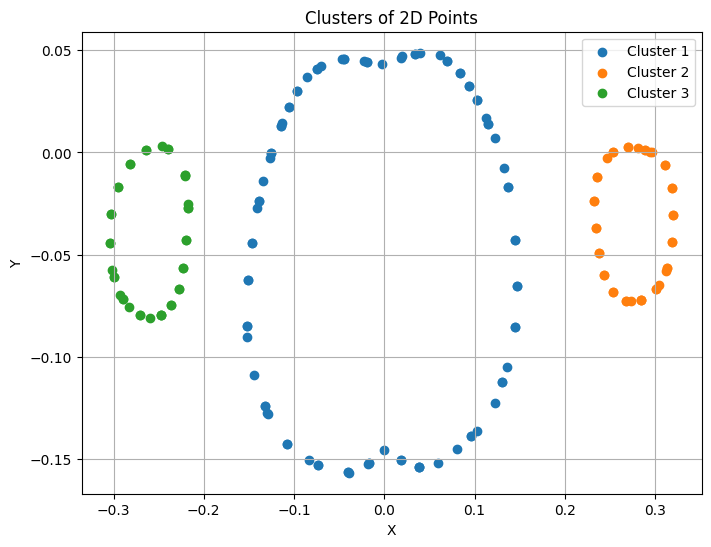

In [51]:
# Extract clusters
unique_labels = set(labels)
clusters = []
for label in unique_labels:
    if label != -1:  # exclude noise points
        cluster = chest_curve[labels == label]
        clusters.append(cluster)

# Plot the clusters
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}')
plt.title('Clusters of 2D Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
y = np.array([0, 1, 0])
phi = -np.arccos(np.dot(normal, y) / (np.linalg.norm(normal) * np.linalg.norm(y)))
theta = -np.arctan2(normal[0], normal[2])

rotX = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])
rotY = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])

for i in range(xyz_chest.shape[0]):
    xyz_chest[i] = np.array(plane.project_point(xyz_chest[i]))

for i in range(xyz_chest.shape[0]):
    xyz_chest[i] = np.dot(rotX, np.dot(rotY, xyz_chest[i]))

xyz_chest = xyz_chest[:, [0, 2]]

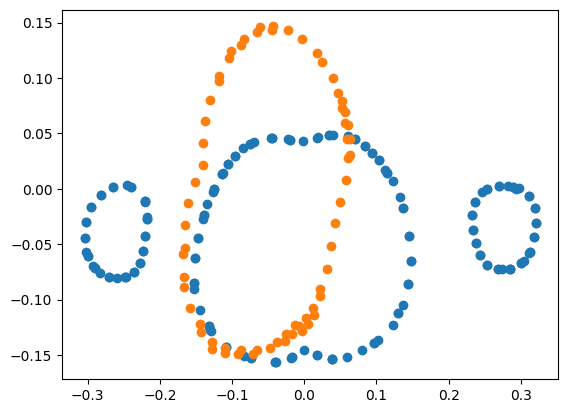

In [63]:
plt.scatter(chest_curve[:,0], chest_curve[:,1])
plt.scatter(xyz_chest[:,0], xyz_chest[:,1])
plt.show()

In [11]:
y_min = -0.2
y_max = 0.2
selected_points = chest_curve[(chest_curve[:, 0] >= y_min) & (chest_curve[:, 0] <= y_max)]

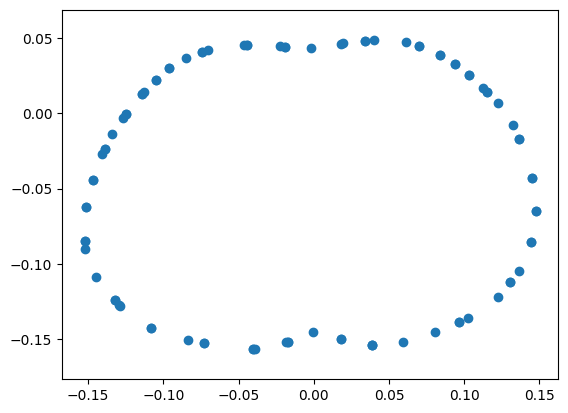

In [12]:
plt.scatter(selected_points[:,0], selected_points[:,1])
plt.axis('equal')
plt.show()

In [13]:
def get_polar_angle(point, center):
    """Calculate the polar angle of a point with respect to the center."""
    dx = point[0] - center[0]
    dy = point[1] - center[1]
    return np.arctan2(dy, dx)

def order_points(selected_points):
    """Order the points based on their polar angles with respect to the centroid."""
    # Find the centroid of the figure
    centroid = np.mean(selected_points, axis=0)
    
    # Calculate polar angles for all points
    polar_angles = [get_polar_angle(point, centroid) for point in selected_points]
    
    # Sort points based on polar angles
    ordered_indices = np.argsort(polar_angles)
    
    # Reorder the points
    ordered_points = selected_points[ordered_indices]
    
    return ordered_points


In [14]:
ordered_points = order_points(selected_points)

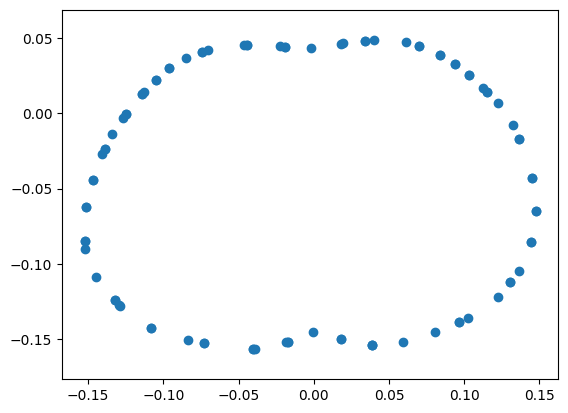

In [15]:
plt.scatter(ordered_points[:,0], ordered_points[:,1])
plt.axis('equal')
plt.show()

In [18]:
y = np.array([0, 1, 0])
phi = np.arccos(np.dot(normal, y) / (np.linalg.norm(normal) * np.linalg.norm(y)))
theta = -np.arctan2(normal[0], normal[2])

rotZ = np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]])
rotY = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])

In [19]:
for i in range(xyz.shape[0]):
    xyz[i] = np.array(plane.project_point(xyz[i]))

for i in range(xyz.shape[0]):
    xyz[i] = np.dot(rotY, xyz[i])

In [20]:
fig = go.Figure(data=[go.Scatter3d(x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2], mode="markers", marker=dict(size=5))])
fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"), title="3D Scatter Plot")
fig.show()

In [63]:
plt.plot(xz[:, 0], xz[:, 1], ".")
plt.show()

NameError: name 'xz' is not defined

In [ ]:
# Generate sample data (replace this with your own 3D points)
points = xyz

# Define the design matrix A
A = np.column_stack((points[:, 0], points[:, 1], np.ones(points.shape[0])))

# Solve for the parameters using lstsq
params, _, _, _ = lstsq(A, points[:, 2])

In [ ]:
params

In [ ]:
from scipy.spatial import ConvexHull


def compute_convex_hull(points):
    """
    Compute the convex hull from a 2D numpy array of points.

    Parameters:
        points (numpy.ndarray): Array of shape (n, 2) representing 2D points.

    Returns:
        numpy.ndarray: Array of shape (m, 2) representing the vertices of the convex hull.
    """
    # Ensure the input is a numpy array
    points = np.array(points)

    # Compute the convex hull
    hull = ConvexHull(points)

    # Get the vertices of the convex hull
    hull_vertices = points[hull.vertices]

    return hull_vertices

In [ ]:
xz = xyz[:, [0, 2]]

In [ ]:
convex_hull = compute_convex_hull(xz)

In [ ]:
plt.plot(xz[:, 0], xz[:, 1], ".")
plt.plot(convex_hull[:, 0], convex_hull[:, 1], ".")
plt.show()

In [16]:
length = 0

for i in range(1, ordered_points.shape[0]):
    length += np.linalg.norm(ordered_points[i] - ordered_points[i - 1])

length += np.linalg.norm(ordered_points[-1] - ordered_points[0])

In [21]:
ordered_points.shape[0]

90

In [22]:
length * 1.73 / smpl_height

0.9088744879671136

In [18]:
length * 1.73 / (0.84 + 0.95)

0.7999285043292551

In [19]:
(0.84 + 0.95) / 1.73

1.0346820809248556

In [ ]:
import numpy as np
from scipy.linalg import lstsq

# Generate sample data (replace this with your own 3D points)
points = np.random.rand(10, 3)

# Define the design matrix A
A = np.column_stack((points[:, 0], points[:, 1], np.ones(points.shape[0])))

# Solve for the parameters using lstsq
params, _, _, _ = lstsq(A, points[:, 2])

In [ ]:
params

In [ ]:
import numpy as np
from scipy.linalg import lstsq

# Generate sample data (replace this with your own 3D points)
points = xyz

# Define the design matrix A
A = np.column_stack((points[:, 0], points[:, 1], points[:, 2], np.ones(points.shape[0])))

# Solve for the parameters using lstsq
params, _, _, _ = lstsq(A, -np.ones(points.shape[0]))

# Extract parameters
a, b, c, d = params

# Print the parameters
print("Parameters of the plane fitting the points:")
print(f"a: {a}, b: {b}, c: {c}, d: {d}")